# 5.4 SAGANの作成

- 本ファイルでは、Self-Attention GANのネットワークを実装と学習をします。


# 5.4 学習目標

1.	SAGANを実装できるようになる


# 事前準備
書籍の指示に従い、本章で使用するデータを用意します

In [1]:
import math
import torch
from torch.optim import Optimizer


class AdaBound(Optimizer):
    """Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss

class AdaBoundW(Optimizer):
    """Implements AdaBound algorithm with Decoupled Weight Decay (arxiv.org/abs/1711.05101)
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBoundW, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBoundW, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                if group['weight_decay'] != 0:
                    decayed_weights = torch.mul(p.data, group['weight_decay'])
                    p.data.add_(-step_size)
                    p.data.sub_(decayed_weights)
                else:
                    p.data.add_(-step_size)

        return loss

In [2]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
from time import time
from PIL import Image
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg
import torchvision
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import xml.etree.ElementTree as ET
import random
from torch.nn.utils import spectral_norm
from scipy.stats import truncnorm
import torch as th

In [3]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


# Self-Attentionモジュールの実装

In [4]:
class Self_Attention(nn.Module):
    """ Self-AttentionのLayer"""

    def __init__(self, in_dim):
        super(Self_Attention, self).__init__()

        # 1×1の畳み込み層によるpointwise convolutionを用意
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)

        # Attention Map作成時の規格化のソフトマックス
        self.softmax = nn.Softmax(dim=-2)

        # 元の入力xとSelf-Attention Mapであるoを足し算するときの係数
        # output = x +gamma*o
        # 最初はgamma=0で、学習させていく
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):

        # 入力変数
        X = x

        # 畳み込みをしてから、サイズを変形する。 B,C',W,H→B,C',N へ
        proj_query = self.query_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C',N
        proj_query = proj_query.permute(0, 2, 1)  # 転置操作
        proj_key = self.key_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C',N

        # かけ算
        S = torch.bmm(proj_query, proj_key)  # bmmはバッチごとの行列かけ算です

        # 規格化
        attention_map_T = self.softmax(S)  # 行i方向の和を1にするソフトマックス関数
        attention_map = attention_map_T.permute(0, 2, 1)  # 転置をとる

        # Self-Attention Mapを計算する
        proj_value = self.value_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C,N
        o = torch.bmm(proj_value, attention_map.permute(
            0, 2, 1))  # Attention Mapは転置してかけ算

        # Self-Attention MapであるoのテンソルサイズをXにそろえて、出力にする
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x+self.gamma*o

        return out, attention_map


# Generatorの実装

In [5]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size * 8,
                                                      kernel_size=4, stride=1)),
            nn.BatchNorm2d(image_size * 8),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 8, image_size * 4,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 4),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 4, image_size * 2,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 2),
            nn.LeakyReLU(0.1, inplace=True))

        # Self-Attentin層を追加
        self.self_attntion1 = Self_Attention(in_dim=image_size * 2)

        self.layer4 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 2, image_size,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size),
            nn.LeakyReLU(0.1, inplace=True))

        # Self-Attentin層を追加
        self.self_attntion2 = Self_Attention(in_dim=image_size)

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 3, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 注意：白黒画像なので出力チャネルは1つだけ

        self.self_attntion2 = Self_Attention(in_dim=64)

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2


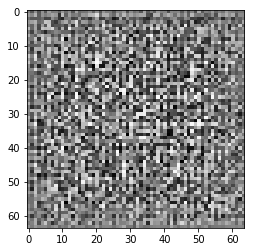

In [6]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=128, image_size=64)

# 入力する乱数
input_z = torch.randn(1, 128)

# テンソルサイズを(1, 20, 1, 1)に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 偽画像を出力
fake_images, attention_map1, attention_map2 = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


# Discriminatorの実装

In [7]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.Conv2d(3, image_size, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.3))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.3))

        self.layer3 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.3))

        # Self-Attentin層を追加
        self.self_attntion1 = Self_Attention(in_dim=image_size*4)

        self.layer4 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.3))

        # Self-Attentin層を追加
        self.self_attntion2 = Self_Attention(in_dim=image_size*8)

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2


In [8]:
# 動作確認
D = Discriminator(z_dim=128, image_size=64)

# 偽画像を生成
input_z = torch.randn(1, 128)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images, _, _ = G(input_z)

# 偽画像をDに入力
d_out, attention_map1, attention_map2 = D(fake_images)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))


tensor([[[[0.5059]]]], grad_fn=<SigmoidBackward>)


# DataLoaderの作成

In [9]:
from functools import partial
from multiprocessing import Pool
import os
from pathlib import Path
import random
import shutil
import time
import xml.etree.ElementTree as ET

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from scipy.stats import truncnorm
import torch
from torch import nn, optim
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets.folder import default_loader
from torchvision.utils import save_image

In [10]:
class DataGenerator(Dataset):
    def __init__(self, directory, transform=None, n_samples=np.inf):
        self.directory = directory
        self.transform = transform
        self.n_samples = n_samples

        self.samples = self._load_subfolders_images(directory)
        if len(self.samples) == 0:
            raise RuntimeError("Found 0 files in subfolders of: {}".format(directory))

    def _load_subfolders_images(self, root):
        IMG_EXTENSIONS = (
        '.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

        def is_valid_file(x):
            return torchvision.datasets.folder.has_file_allowed_extension(x, IMG_EXTENSIONS)

        required_transforms = torchvision.transforms.Compose([
                torchvision.transforms.Resize(64),
                torchvision.transforms.CenterCrop(64),
        ])

        imgs = []
        paths = []
        for root, _, fnames in sorted(os.walk(root)):
            for fname in sorted(fnames)[:min(self.n_samples, 999999999999999)]:
                path = os.path.join(root, fname)
                paths.append(path)

        for path in paths:
            if is_valid_file(path):
                # Load image
                img = dset.folder.default_loader(path)

                # Get bounding boxes
                annotation_basename = os.path.splitext(os.path.basename(path))[0]
                annotation_dirname = next(
                        dirname for dirname in os.listdir('../input/annotation/Annotation/') if
                        dirname.startswith(annotation_basename.split('_')[0]))
                annotation_filename = os.path.join('../input/annotation/Annotation/',
                                                   annotation_dirname, annotation_basename)
                tree = ET.parse(annotation_filename)
                root = tree.getroot()
                objects = root.findall('object')
                for o in objects:
                    bndbox = o.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    
                    w = np.min((xmax - xmin, ymax - ymin))
                    bbox = (xmin, ymin, xmin+w, ymin+w)
                    object_img = required_transforms(img.crop(bbox))
                    #object_img = object_img.resize((64,64), Image.ANTIALIAS)
                    imgs.append(object_img)
        return imgs

    def __getitem__(self, index):
        sample = self.samples[index]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return np.asarray(sample)
    
    def __len__(self):
        return len(self.samples)

In [15]:
%%time
batch_size = 64
database = '../input/all-dogs/all-dogs/'

transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DataGenerator(database, transform=transform,n_samples=25000)


train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,batch_size=batch_size, num_workers = 4)

CPU times: user 1min 15s, sys: 4.38 s, total: 1min 19s
Wall time: 1min 42s


# 学習させる

In [16]:
# モデルを学習させる関数を作成
def train_model(G, D, dataloader, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    g_lr, d_lr = 0.00005, 0.01
    beta1, beta2 = 0.5, 0.999
    g_optimizer = AdaBoundW(G.parameters(), lr=g_lr, betas=(beta1, beta2), final_lr=0.1,weight_decay=5e-4)
#    d_optimizer = AdaBoundW(D.parameters(), lr=d_lr, betas=(beta1, beta2), final_lr=0.1,weight_decay=5e-4)
    d_optimizer = optim.SGD(D.parameters(), lr=d_lr)
    
    lr_schedulerG = optim.lr_scheduler.CosineAnnealingWarmRestarts(g_optimizer,
                                                                     T_0=num_epochs//200, eta_min=0.00005)
    lr_schedulerD = optim.lr_scheduler.CosineAnnealingWarmRestarts(d_optimizer,
                                                                     T_0=num_epochs//200, eta_min=0.00005)
 
    # 誤差関数を定義 → hinge version of the adversarial lossに変更
    # criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 128
    mini_batch_size = batch_size

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []
    d_loss_log = []
    g_loss_log = []
    dout_real_log = []
    dout_fake_log = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和
        epoch_dout_real = 0.0
        epoch_dout_fake = 0.0

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            #label_real = torch.full((mini_batch_size,), 1).to(device)
            #label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 真の画像を判定
            d_out_real, _, _ = D(imges)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)

            # 誤差を計算→hinge version of the adversarial lossに変更
            # d_loss_real = criterion(d_out_real.view(-1), label_real)
            # d_loss_fake = criterion(d_out_fake.view(-1), label_fake)

            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
            # 誤差　d_out_realが1以上で誤差0になる。d_out_real>1で、
            # 1.0 - d_out_realが負の場合ReLUで0にする

            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
            # 誤差　d_out_fakeが-1以下なら誤差0になる。d_out_fake<-1で、
            # 1.0 + d_out_realが負の場合ReLUで0にする

            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake2, _, _ = D(fake_images)

            # 誤差を計算→hinge version of the adversarial lossに変更
            #g_loss = criterion(d_out_fake.view(-1), label_real)
            g_loss = - d_out_fake2.mean()

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_dout_real += d_out_real.mean().item()
            epoch_dout_fake += d_out_fake.mean().item()
            iteration += 1
            
            lr_schedulerG.step(epoch)
            lr_schedulerD.step(epoch)

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||dout_r:{:.4f},dout_f:{:.4f}'.format(
            epoch, epoch_d_loss/batch, epoch_g_loss/batch, epoch_dout_real/batch, epoch_dout_fake/batch))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        d_loss_log.append(epoch_d_loss/batch)
        g_loss_log.append(epoch_g_loss/batch)
        dout_real_log.append(epoch_dout_real/batch)
        dout_fake_log.append(epoch_dout_fake/batch)
        
        if epoch % 30 == 0:
            # 生成画像と訓練データを可視化する
            # 本セルは、良い感じの画像が生成されるまで、何度か実行をし直しています

            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

            # 入力の乱数生成
            sample_batch_size = 8
            z_dim = 128
            fixed_z = torch.randn(sample_batch_size, z_dim)
            fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

            # 画像生成
            fake_images, am1, am2 = G(fixed_z.to(device))
            fake_images = fake_images.cpu().detach().numpy().transpose(0, 2, 3, 1)

            # 訓練データ
            batch_iterator = iter(train_loader)  # イテレータに変換
            imges = next(batch_iterator)  # 1番目の要素を取り出す
            imges = imges.cpu().detach().numpy().transpose(0, 2, 3, 1)


            # 出力
            fig = plt.figure(figsize=(15, 6))
            for i in range(0, 5):
                # 上段に訓練データを
                plt.subplot(2, 5, i+1)
                plt.imshow(imges[i])

                # 下段に生成データを表示する
                plt.subplot(2, 5, 5+i+1)
                plt.imshow(fake_images[i])
            plt.show()

    # print("総イテレーション回数:", iteration)

    return G, D, d_loss_log, g_loss_log, dout_real_log, dout_fake_log


In [17]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")


ネットワークの初期化完了


使用デバイス： cuda:0
-------------
Epoch 0/300
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:5.7486 ||Epoch_G_Loss:6.1170 ||dout_r:14.4480,dout_f:-4.1122
timer:  42.8837 sec.


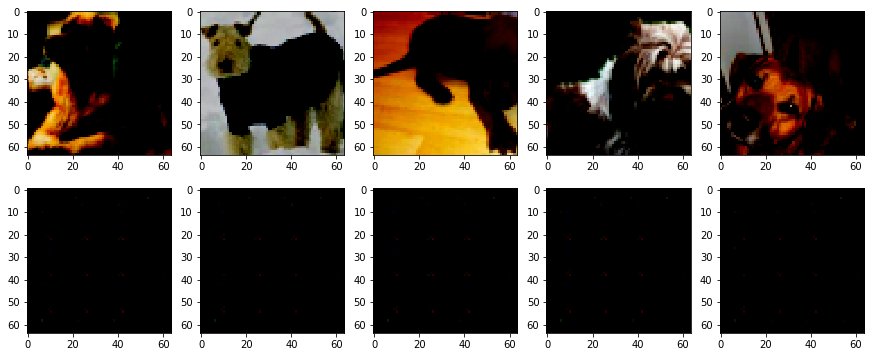

-------------
Epoch 1/300
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:8.3949 ||Epoch_G_Loss:4.3851 ||dout_r:4.4595,dout_f:-3.0918
timer:  41.8259 sec.
-------------
Epoch 2/300
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:9.7828 ||Epoch_G_Loss:2.7103 ||dout_r:-0.0119,dout_f:-1.4103
timer:  41.7841 sec.
-------------
Epoch 3/300
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:9.8892 ||Epoch_G_Loss:2.5769 ||dout_r:-0.1146,dout_f:-1.2992
timer:  41.8312 sec.
-------------
Epoch 4/300
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:9.8150 ||Epoch_G_Loss:2.6480 ||dout_r:0.2146,dout_f:-1.0817
timer:  41.8643 sec.
-------------
Epoch 5/300
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:10.1522 ||Epoch_G_Loss:2.3064 ||dout_r:-0.0804,dout_f:-0.9172
timer:  41.7961 sec.
-------------
Epoch 6/300
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:10.1228 ||Epoch_G_Loss:2.1021 ||dout_r:0.0426,dout_f:-0.7891
timer:  41.737

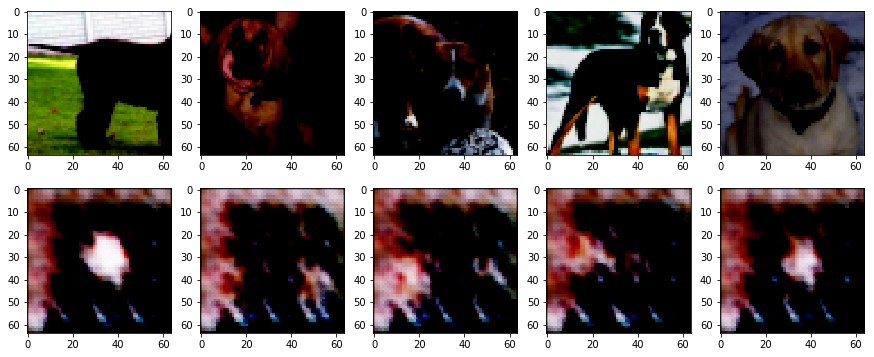

-------------
Epoch 31/300
-------------
（train）
-------------
epoch 31 || Epoch_D_Loss:10.8119 ||Epoch_G_Loss:1.7298 ||dout_r:-1.7261,dout_f:-1.7267
timer:  41.7151 sec.
-------------
Epoch 32/300
-------------
（train）
-------------
epoch 32 || Epoch_D_Loss:10.8096 ||Epoch_G_Loss:1.6951 ||dout_r:-1.6883,dout_f:-1.6913
timer:  41.8364 sec.
-------------
Epoch 33/300
-------------
（train）
-------------
epoch 33 || Epoch_D_Loss:10.8194 ||Epoch_G_Loss:1.7268 ||dout_r:-1.7316,dout_f:-1.7246
timer:  41.7713 sec.
-------------
Epoch 34/300
-------------
（train）
-------------
epoch 34 || Epoch_D_Loss:10.8134 ||Epoch_G_Loss:1.7019 ||dout_r:-1.6997,dout_f:-1.6988
timer:  41.7405 sec.
-------------
Epoch 35/300
-------------
（train）
-------------
epoch 35 || Epoch_D_Loss:10.8127 ||Epoch_G_Loss:1.6752 ||dout_r:-1.6752,dout_f:-1.6751
timer:  41.6946 sec.
-------------
Epoch 36/300
-------------
（train）
-------------
epoch 36 || Epoch_D_Loss:10.8125 ||Epoch_G_Loss:1.6937 ||dout_r:-1.6932,dout_f:-1.

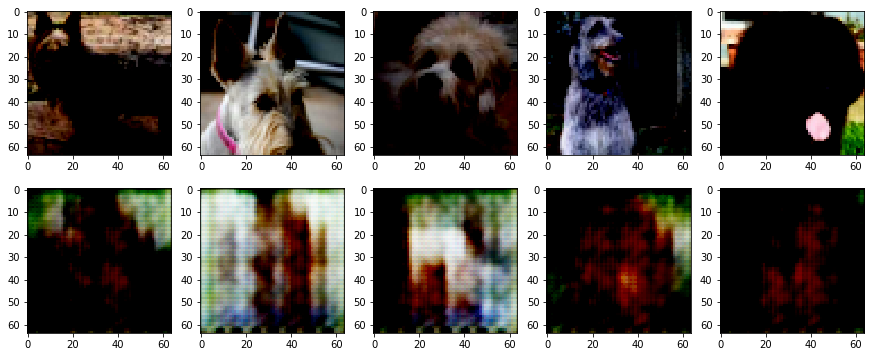

-------------
Epoch 61/300
-------------
（train）
-------------
epoch 61 || Epoch_D_Loss:10.8128 ||Epoch_G_Loss:1.4995 ||dout_r:-1.4980,dout_f:-1.4977
timer:  41.7543 sec.
-------------
Epoch 62/300
-------------
（train）
-------------
epoch 62 || Epoch_D_Loss:10.8146 ||Epoch_G_Loss:1.4807 ||dout_r:-1.4837,dout_f:-1.4816
timer:  41.6658 sec.
-------------
Epoch 63/300
-------------
（train）
-------------
epoch 63 || Epoch_D_Loss:10.8069 ||Epoch_G_Loss:1.4619 ||dout_r:-1.4529,dout_f:-1.4585
timer:  41.7794 sec.
-------------
Epoch 64/300
-------------
（train）
-------------
epoch 64 || Epoch_D_Loss:10.8137 ||Epoch_G_Loss:1.4535 ||dout_r:-1.4520,dout_f:-1.4508
timer:  41.6910 sec.
-------------
Epoch 65/300
-------------
（train）
-------------
epoch 65 || Epoch_D_Loss:10.8067 ||Epoch_G_Loss:1.4257 ||dout_r:-1.4147,dout_f:-1.4206
timer:  41.8225 sec.
-------------
Epoch 66/300
-------------
（train）
-------------
epoch 66 || Epoch_D_Loss:10.8108 ||Epoch_G_Loss:1.4747 ||dout_r:-1.4673,dout_f:-1.

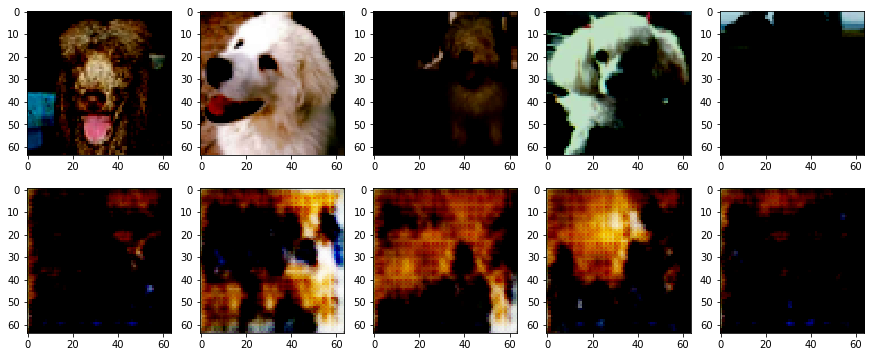

-------------
Epoch 91/300
-------------
（train）
-------------
epoch 91 || Epoch_D_Loss:10.7675 ||Epoch_G_Loss:0.9569 ||dout_r:-0.8290,dout_f:-0.8740
timer:  41.6993 sec.
-------------
Epoch 92/300
-------------
（train）
-------------
epoch 92 || Epoch_D_Loss:10.7036 ||Epoch_G_Loss:0.5785 ||dout_r:-0.2013,dout_f:-0.3138
timer:  41.7067 sec.
-------------
Epoch 93/300
-------------
（train）
-------------
epoch 93 || Epoch_D_Loss:10.2256 ||Epoch_G_Loss:1.8262 ||dout_r:0.0139,dout_f:-0.6924
timer:  42.1897 sec.
-------------
Epoch 94/300
-------------
（train）
-------------
epoch 94 || Epoch_D_Loss:9.1252 ||Epoch_G_Loss:4.1559 ||dout_r:0.4228,dout_f:-1.8513
timer:  41.8946 sec.
-------------
Epoch 95/300
-------------
（train）
-------------
epoch 95 || Epoch_D_Loss:9.3432 ||Epoch_G_Loss:4.2186 ||dout_r:0.1590,dout_f:-1.9100
timer:  41.8124 sec.
-------------
Epoch 96/300
-------------
（train）
-------------
epoch 96 || Epoch_D_Loss:9.6770 ||Epoch_G_Loss:3.6108 ||dout_r:-0.2939,dout_f:-1.8071
t

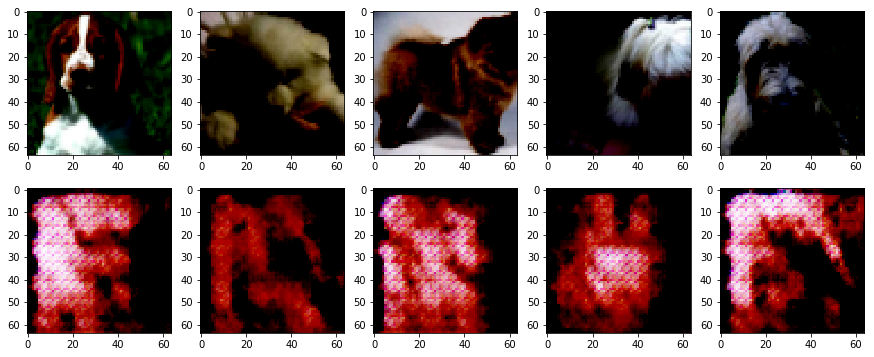

-------------
Epoch 121/300
-------------
（train）
-------------
epoch 121 || Epoch_D_Loss:2.7851 ||Epoch_G_Loss:10.5549 ||dout_r:8.6378,dout_f:-8.9409
timer:  41.6978 sec.
-------------
Epoch 122/300
-------------
（train）
-------------
epoch 122 || Epoch_D_Loss:3.0625 ||Epoch_G_Loss:10.8830 ||dout_r:8.3691,dout_f:-8.9857
timer:  41.6924 sec.
-------------
Epoch 123/300
-------------
（train）
-------------
epoch 123 || Epoch_D_Loss:2.1939 ||Epoch_G_Loss:11.3725 ||dout_r:11.7796,dout_f:-9.6063
timer:  41.8621 sec.
-------------
Epoch 124/300
-------------
（train）
-------------
epoch 124 || Epoch_D_Loss:3.1827 ||Epoch_G_Loss:10.3500 ||dout_r:8.4532,dout_f:-8.4436
timer:  41.7862 sec.
-------------
Epoch 125/300
-------------
（train）
-------------
epoch 125 || Epoch_D_Loss:2.6677 ||Epoch_G_Loss:11.8922 ||dout_r:9.7868,dout_f:-10.2000
timer:  41.7147 sec.
-------------
Epoch 126/300
-------------
（train）
-------------
epoch 126 || Epoch_D_Loss:2.9771 ||Epoch_G_Loss:11.1960 ||dout_r:8.9820,do

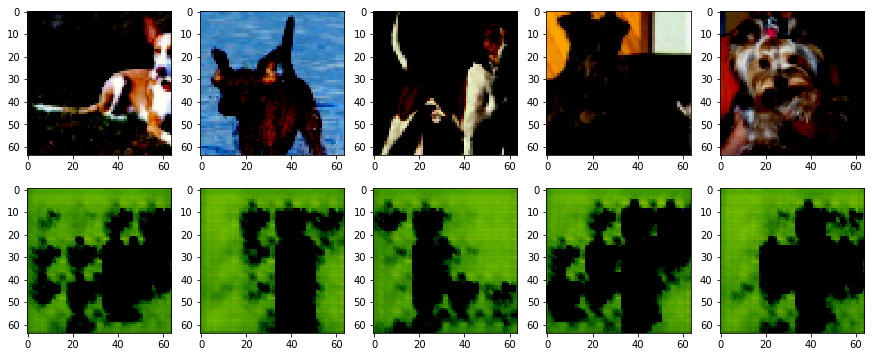

-------------
Epoch 151/300
-------------
（train）
-------------
epoch 151 || Epoch_D_Loss:1.8334 ||Epoch_G_Loss:13.3743 ||dout_r:11.8445,dout_f:-11.7952
timer:  41.8168 sec.
-------------
Epoch 152/300
-------------
（train）
-------------
epoch 152 || Epoch_D_Loss:2.2218 ||Epoch_G_Loss:13.2834 ||dout_r:11.1552,dout_f:-11.6175
timer:  41.9566 sec.
-------------
Epoch 153/300
-------------
（train）
-------------
epoch 153 || Epoch_D_Loss:2.4986 ||Epoch_G_Loss:12.2892 ||dout_r:10.4707,dout_f:-10.1748
timer:  41.7885 sec.
-------------
Epoch 154/300
-------------
（train）
-------------
epoch 154 || Epoch_D_Loss:2.0117 ||Epoch_G_Loss:12.6679 ||dout_r:11.2171,dout_f:-11.0449
timer:  41.7220 sec.
-------------
Epoch 155/300
-------------
（train）
-------------
epoch 155 || Epoch_D_Loss:2.3612 ||Epoch_G_Loss:12.5821 ||dout_r:11.1958,dout_f:-10.7987
timer:  41.7666 sec.
-------------
Epoch 156/300
-------------
（train）
-------------
epoch 156 || Epoch_D_Loss:2.6915 ||Epoch_G_Loss:11.1923 ||dout_r:9

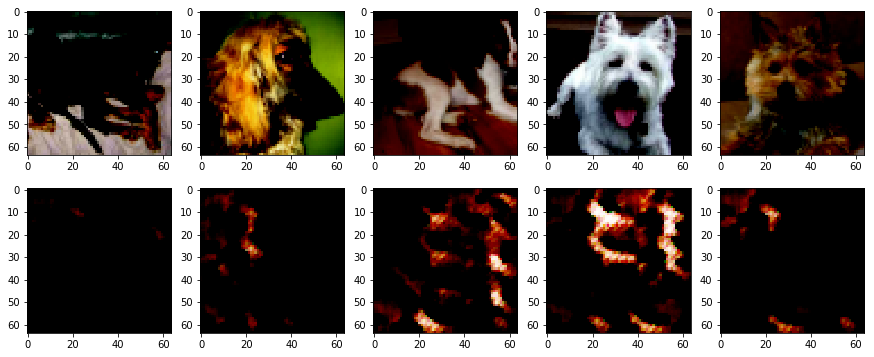

-------------
Epoch 181/300
-------------
（train）
-------------
epoch 181 || Epoch_D_Loss:2.3662 ||Epoch_G_Loss:12.1022 ||dout_r:10.3132,dout_f:-10.4818
timer:  41.8987 sec.
-------------
Epoch 182/300
-------------
（train）
-------------
epoch 182 || Epoch_D_Loss:1.9213 ||Epoch_G_Loss:14.8195 ||dout_r:11.2481,dout_f:-13.1342
timer:  41.7869 sec.
-------------
Epoch 183/300
-------------
（train）
-------------
epoch 183 || Epoch_D_Loss:2.6165 ||Epoch_G_Loss:12.6698 ||dout_r:9.8889,dout_f:-10.8822
timer:  41.7499 sec.
-------------
Epoch 184/300
-------------
（train）
-------------
epoch 184 || Epoch_D_Loss:1.7676 ||Epoch_G_Loss:12.5916 ||dout_r:12.5738,dout_f:-11.1589
timer:  41.7672 sec.
-------------
Epoch 185/300
-------------
（train）
-------------
epoch 185 || Epoch_D_Loss:2.2307 ||Epoch_G_Loss:13.5587 ||dout_r:10.5745,dout_f:-11.9355
timer:  41.8241 sec.
-------------
Epoch 186/300
-------------
（train）
-------------
epoch 186 || Epoch_D_Loss:2.1355 ||Epoch_G_Loss:13.8843 ||dout_r:11

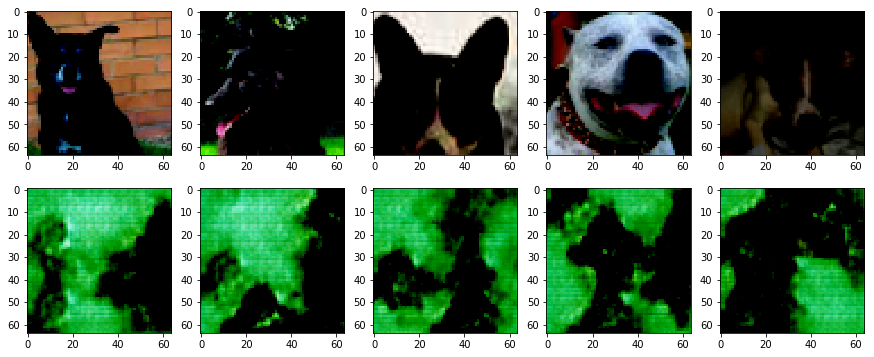

-------------
Epoch 211/300
-------------
（train）
-------------
epoch 211 || Epoch_D_Loss:1.8575 ||Epoch_G_Loss:14.1096 ||dout_r:12.1443,dout_f:-12.6780
timer:  41.7845 sec.
-------------
Epoch 212/300
-------------
（train）
-------------
epoch 212 || Epoch_D_Loss:1.9172 ||Epoch_G_Loss:12.9712 ||dout_r:12.3522,dout_f:-11.4818
timer:  41.7569 sec.
-------------
Epoch 213/300
-------------
（train）
-------------
epoch 213 || Epoch_D_Loss:2.2427 ||Epoch_G_Loss:14.0234 ||dout_r:11.0259,dout_f:-12.0234
timer:  41.7959 sec.
-------------
Epoch 214/300
-------------
（train）
-------------
epoch 214 || Epoch_D_Loss:2.2292 ||Epoch_G_Loss:13.3435 ||dout_r:10.5487,dout_f:-11.7400
timer:  41.7525 sec.
-------------
Epoch 215/300
-------------
（train）
-------------
epoch 215 || Epoch_D_Loss:1.9923 ||Epoch_G_Loss:14.9533 ||dout_r:11.4857,dout_f:-13.1813
timer:  41.7503 sec.
-------------
Epoch 216/300
-------------
（train）
-------------
epoch 216 || Epoch_D_Loss:1.8353 ||Epoch_G_Loss:13.5365 ||dout_r:1

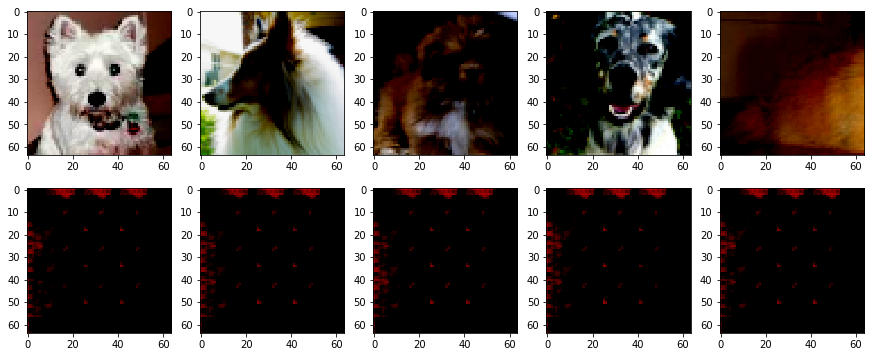

-------------
Epoch 241/300
-------------
（train）
-------------
epoch 241 || Epoch_D_Loss:1.6658 ||Epoch_G_Loss:12.8708 ||dout_r:13.2659,dout_f:-11.2857
timer:  41.8250 sec.
-------------
Epoch 242/300
-------------
（train）
-------------
epoch 242 || Epoch_D_Loss:1.6092 ||Epoch_G_Loss:14.0528 ||dout_r:14.9437,dout_f:-12.8225
timer:  41.7482 sec.
-------------
Epoch 243/300
-------------
（train）
-------------
epoch 243 || Epoch_D_Loss:2.0955 ||Epoch_G_Loss:13.7184 ||dout_r:11.7426,dout_f:-11.8846
timer:  41.7985 sec.
-------------
Epoch 244/300
-------------
（train）
-------------
epoch 244 || Epoch_D_Loss:2.0293 ||Epoch_G_Loss:13.2032 ||dout_r:11.8601,dout_f:-11.6762
timer:  41.7542 sec.
-------------
Epoch 245/300
-------------
（train）
-------------
epoch 245 || Epoch_D_Loss:2.2495 ||Epoch_G_Loss:13.1391 ||dout_r:11.0178,dout_f:-11.3233
timer:  41.7587 sec.
-------------
Epoch 246/300
-------------
（train）
-------------
epoch 246 || Epoch_D_Loss:1.9986 ||Epoch_G_Loss:13.0093 ||dout_r:1

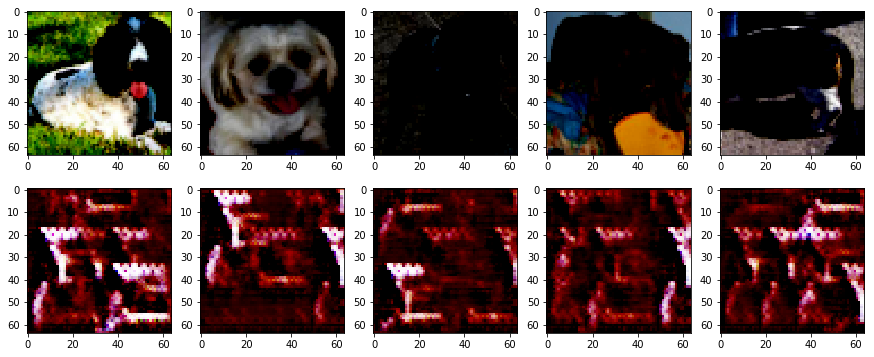

-------------
Epoch 271/300
-------------
（train）
-------------
epoch 271 || Epoch_D_Loss:2.2349 ||Epoch_G_Loss:13.3141 ||dout_r:11.5805,dout_f:-11.5465
timer:  41.8008 sec.
-------------
Epoch 272/300
-------------
（train）
-------------
epoch 272 || Epoch_D_Loss:2.2551 ||Epoch_G_Loss:12.9203 ||dout_r:10.9395,dout_f:-11.1957
timer:  41.7726 sec.
-------------
Epoch 273/300
-------------
（train）
-------------
epoch 273 || Epoch_D_Loss:0.6687 ||Epoch_G_Loss:15.7320 ||dout_r:19.3562,dout_f:-15.1827
timer:  41.7796 sec.
-------------
Epoch 274/300
-------------
（train）
-------------
epoch 274 || Epoch_D_Loss:0.0161 ||Epoch_G_Loss:16.0819 ||dout_r:25.9632,dout_f:-16.0552
timer:  41.7602 sec.
-------------
Epoch 275/300
-------------
（train）
-------------
epoch 275 || Epoch_D_Loss:0.9905 ||Epoch_G_Loss:14.1973 ||dout_r:18.5525,dout_f:-13.2695
timer:  41.7950 sec.
-------------
Epoch 276/300
-------------
（train）
-------------
epoch 276 || Epoch_D_Loss:1.3726 ||Epoch_G_Loss:13.3225 ||dout_r:1

In [18]:
# 学習・検証を実行する
# 15分ほどかかる
num_epochs = 300
G_update, D_update, d_loss_log, g_loss_log, dout_real_log, dout_fake_log = train_model(
    G, D, dataloader=train_loader, num_epochs=num_epochs)


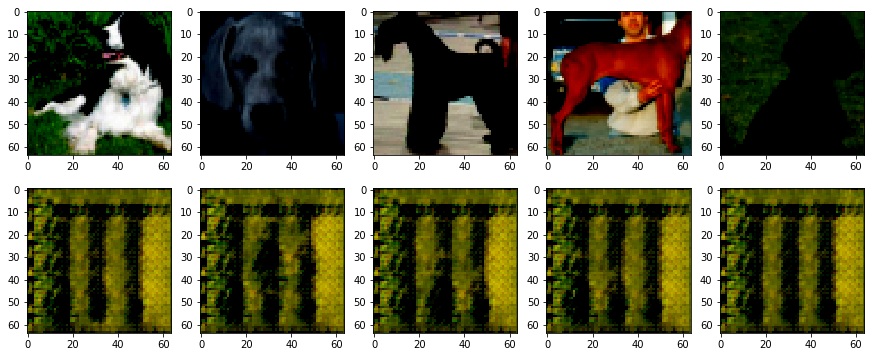

In [19]:
# 生成画像と訓練データを可視化する
# 本セルは、良い感じの画像が生成されるまで、何度か実行をし直しています

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 128
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images, am1, am2 = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_loader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i].cpu().detach().numpy().transpose(1, 2, 0))

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i].cpu().detach().numpy().transpose(1, 2, 0))


In [21]:
def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 64
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    z = truncated_normal((im_batch_size, z_dim, 1, 1), threshold=1)
    gen_z = torch.from_numpy(z).float().to(device)    
    #gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images,_,_ = G_update(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image((gen_images[i_image, :, :, :] +1.0)/2.0, os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'

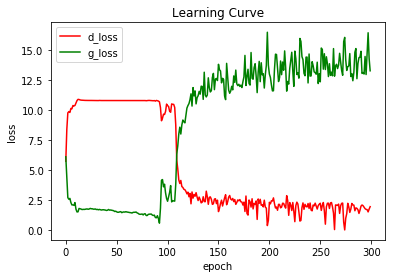

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(d_loss_log,   color="r", label="d_loss")
plt.plot(g_loss_log,   color="g", label="g_loss")

plt.legend(loc="best")

plt.show()


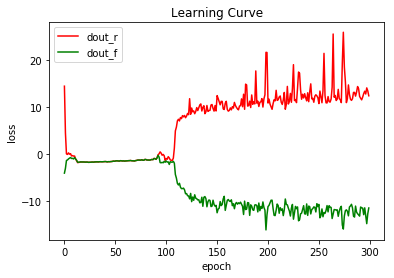

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(dout_real_log, color="r", label="dout_r")
plt.plot(dout_fake_log, color="g", label="dout_f")

plt.legend(loc="best")

plt.show()


以上